# Conhecimentos Técnicos - Cientista de Dados Oncase

### Este projeto de Time Series é o 3º de  4 etapas do teste de conhecimento para vaga de cientista de dados da empresa Oncase.
Author: Dorivan Kadatz Borba<br>
Coding: utf-8<br>
Language: PT-BR

# Montando o driver e importando pacotes

In [339]:
'''!pip install xgboost --upgrade
!pip install catboost
!pip install lightgbm 
#!pip install seaborn==0.12.1'''

'!pip install xgboost --upgrade\n!pip install catboost\n!pip install lightgbm \n#!pip install seaborn==0.12.1'

In [340]:
'''from google.colab import drive
drive.mount('/content/drive')'''

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split

from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from lightgbm import LGBMRegressor

import matplotlib.pyplot as plt
import seaborn as sns
import seaborn.objects as so # Necessário seaborn 0.12.1 ou maior
from matplotlib import style

from sklearn.metrics import r2_score, mean_absolute_error, mean_absolute_percentage_error, mean_squared_log_error, mean_squared_error
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

import holidays
from datetime import datetime

# Importando os dados

In [341]:
# importa os dados de treino e teste do google drive.
df= pd.read_excel("time_series_data.xlsx")

In [342]:
df

,produto_descricao,produto_quantidade,produto_unidade_comercial,produto_valor_unitario_comercializacao,nota_data_emissao
0,A0,23568,UN,14.1300,20210420
1,A0,25082,UN,14.1300,20210420
2,A0,25430,UN,14.1300,20210922
3,A0,25463,UN,12.8400,20210209
4,A0,25800,UN,12.8400,20210209
...,...,...,...,...,...
4455,B3,60,UN,3.1500,20210125
4456,B3,85,UN,3.1500,20210120
4457,B0,11400,UN,4.6477,20210226
4458,B0,22800,UN,4.6477,20210226


In [343]:
# Verificando a quantidade de observações, tipo dos dados e se existe dados nulos.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4460 entries, 0 to 4459
Data columns (total 5 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   produto_descricao                       4460 non-null   object 
 1   produto_quantidade                      4460 non-null   int64  
 2   produto_unidade_comercial               4460 non-null   object 
 3   produto_valor_unitario_comercializacao  4460 non-null   float64
 4   nota_data_emissao                       4460 non-null   int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 174.3+ KB


# Tratamento da featue nota_data_emissao para o tipo datetime

In [344]:
# Loop for, faz um slice em cada item da feature nota_data_emissao para transformação em date time
data = []
for item in df['nota_data_emissao']:
  item = str(item) # daca item da feature será alterada para o tipo string
  ano = int(item[0:4]) # slice dos 4 primeiros digitos e armazeno com o tipo inteiro
  mes = int(item[4:6]) # slice para o mês
  dia = int(item[6:8]) # slice para o dia
  data.append(datetime(ano, mes, dia)) # Armazena a lista data com os dados transfomadoos para date time


In [345]:
# Nova feature no data frame com os dados da variável data
df['data_emissao_nota'] = data

In [346]:
# Seta a feature data_emissao_nota como index
df.sort_values(by='data_emissao_nota', inplace=True)
df

,produto_descricao,produto_quantidade,produto_unidade_comercial,produto_valor_unitario_comercializacao,nota_data_emissao,data_emissao_nota
4393,A9,5,UN,134.11,20201001,2020-10-01
4395,B0,120,UN,29.50,20201001,2020-10-01
3932,B3,24,UN,3.19,20201001,2020-10-01
3800,A8,1,UN,1.90,20201002,2020-10-02
3946,B4,7,UN,1.74,20201002,2020-10-02
...,...,...,...,...,...,...
1342,A8,45,UN,8.48,20210930,2021-09-30
3029,B2,12000,UN,11.42,20210930,2021-09-30
1870,B1,45,UN,8.38,20210930,2021-09-30
2109,A8,495,UN,8.60,20210930,2021-09-30


In [347]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4460 entries, 4393 to 100
Data columns (total 6 columns):
 #   Column                                  Non-Null Count  Dtype         
---  ------                                  --------------  -----         
 0   produto_descricao                       4460 non-null   object        
 1   produto_quantidade                      4460 non-null   int64         
 2   produto_unidade_comercial               4460 non-null   object        
 3   produto_valor_unitario_comercializacao  4460 non-null   float64       
 4   nota_data_emissao                       4460 non-null   int64         
 5   data_emissao_nota                       4460 non-null   datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int64(2), object(2)
memory usage: 243.9+ KB


# Selecionando o produto para predição

In [348]:
# Conta quantas observações de cada produto o data frame tem.
df.groupby('produto_descricao')['produto_descricao'].count().sort_values(ascending=False)

produto_descricao
B0    1000
B3     887
B2     778
A8     662
B1     536
B4     307
A9     141
D0      33
A0      32
B6      17
A7      14
A5       8
B7       6
A6       6
C5       4
C3       3
C0       3
C1       3
B8       2
B5       2
C2       2
C7       2
C9       2
D1       2
B9       1
A1       1
A3       1
C4       1
A4       1
C6       1
C8       1
A2       1
Name: produto_descricao, dtype: int64

- Para o modelo de previsão de vendas de produto, irei utilizar o produto B0, pois é o que contém mais observações.

In [375]:
# Seleciona todos os dados do produto B0
df_B0 = df.query('produto_descricao == "B0"')

In [350]:
df_B0.head()

,produto_descricao,produto_quantidade,produto_unidade_comercial,produto_valor_unitario_comercializacao,nota_data_emissao,data_emissao_nota
4395,B0,120,UN,29.50,20201001,2020-10-01
3945,B0,14,UN,0.97,20201002,2020-10-02
3881,B0,1,UN,0.97,20201005,2020-10-05
3848,B0,25,UN,0.88,20201007,2020-10-07
3940,B0,2,UN,0.88,20201007,2020-10-07


- Para um modelo de previsão de vendas, temos que montar uma series que contem informações que fazem sentido na venda do produto, que pode influenciar a venda como por exemplo: data de venda, feriados, valor unitário, quantidade de vendas...

# Time features

In [376]:
# Selecionando as featues necessárias
df_B0 = df_B0[['produto_quantidade', 'data_emissao_nota']]
df_B0.head()

,produto_quantidade,data_emissao_nota
4395,120,2020-10-01
3945,14,2020-10-02
3881,1,2020-10-05
3848,25,2020-10-07
3940,2,2020-10-07


In [377]:
# Seta a feature data_emissao_nota como indice do data frame
df_B0.set_index('data_emissao_nota', inplace=True)
# Ordena o indice do menor para o maior
df_B0.sort_index(inplace=True)

In [378]:
# PREPARANDO OS DADOS

# Agrupa os dados por data e dia, e atribui o total de venda do dia
#previsao_df = pd.DataFrame(df.groupby([df.index, 'StoreID'])['TotalPurchase'].sum())
previsao_df_B0 = pd.DataFrame(df_B0['produto_quantidade'].resample('w').sum())


# Reseta o indice, já que o dataframe retornou dois indices
#previsao_df.reset_index(inplace=True)

# Reatribui a data de compra como indice
#previsao_df_B0.set_index('data_emissao_nota', inplace=True)


# Irei utilizar o XGboost para o modelo de regressão, esse é um modelo supervisionado, diferente dos modelos estatísticos
# nesse eu preciso criar novas features de serie temporal, os modelos estatísticos trabalham bem com o indice do tipo datetime.
def create_features(df):
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return df

# Chama a função e cria as colunas de caracteristica temporal
create_features(previsao_df_B0)

previsao_df_B0['weekofyear'] = np.int8(previsao_df_B0['weekofyear'])

# Ordena o indice do menor para o maior
previsao_df_B0.sort_index(inplace=True)

#### Separando os dados para treino, validação.

In [379]:
# Separa os dados para a validação final
df_validation = previsao_df_B0[-4:]
previsao_df_B0 = previsao_df_B0[:-4]

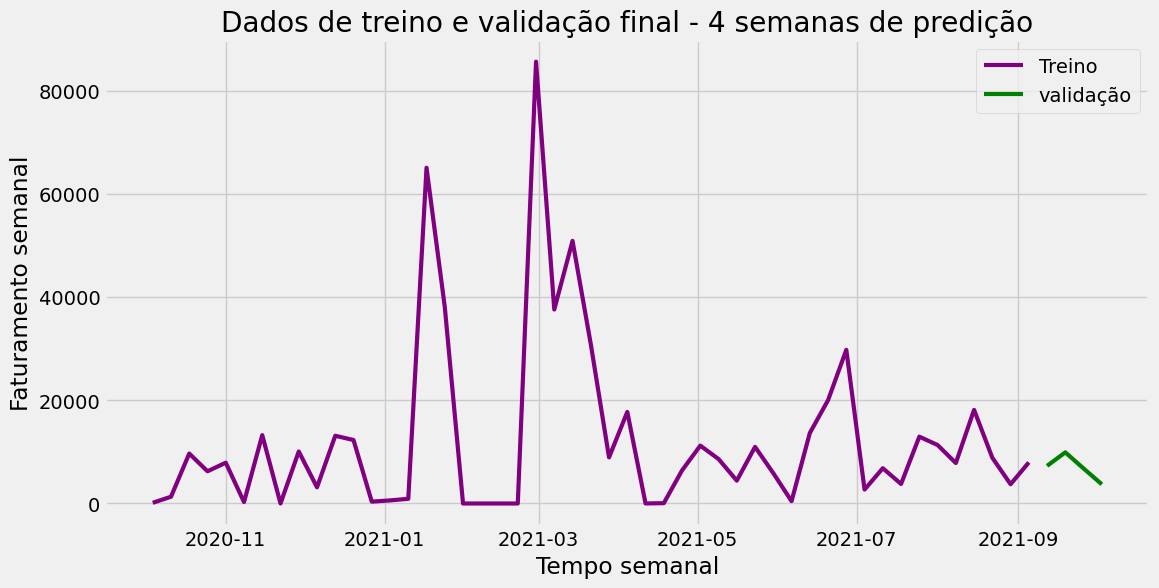

In [380]:
# Mostra o grafico de linha com os dados de treino e teste, observação para apenas 4 semanas de predição.
plt.style.use('fivethirtyeight')
fig, ax = plt.subplots()

ax = sns.lineplot(x = previsao_df_B0.index, y = previsao_df_B0['produto_quantidade'], color = 'purple', label='Treino', lw=3)
ax = sns.lineplot(x = df_validation.index, y = df_validation['produto_quantidade'], color = 'green',label='validação', lw=3)
ax.set_xlabel('Tempo semanal')
ax.set_ylabel('Faturamento semanal')
ax.set_title('Dados de treino e validação final - 4 semanas de predição')
fig.set_size_inches(12,6)

In [361]:
# Função para retornar uma serie de metricas de avaliação
def metricas_de_avaliacao(y_true, y_pred):
    print(
    'MAE: ',np.round(mean_absolute_error(y_true, y_pred), 2),'\n',
    'RMSE: ',np.round(np.sqrt(mean_squared_error(y_true, y_pred)), 2),'\n',
    'MAPE: ',np.round(mean_absolute_percentage_error(y_true, y_pred), 2),'\n',
    'R2: ',np.round(r2_score(y_true, y_pred), 2))

# CatBoost Regressor

In [280]:
previsao_df_B0.tail()

,produto_quantidade,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,lag8w,lag10w
data_emissao_nota,,,,,,,,,,
2021-08-08,7847,6,3,8,2021,220,8,31,13659.0,5880.0
2021-08-15,18157,6,3,8,2021,227,15,32,20040.0,455.0
2021-08-22,8868,6,3,8,2021,234,22,33,29801.0,13659.0
2021-08-29,3736,6,3,8,2021,241,29,34,2700.0,20040.0
2021-09-05,7964,6,3,9,2021,248,5,35,6840.0,29801.0


In [383]:
# Separa os dados para treino e teste
size = 4
train = previsao_df_B0[:-size]
validation = previsao_df_B0[-size:]

X_test = validation.drop(columns='produto_quantidade')
y_test = validation['produto_quantidade']

X_train = previsao_df_B0.drop(columns='produto_quantidade')
y_train = previsao_df_B0['produto_quantidade']

In [403]:
# Instancia o modelo com os parametros encontrado
cat_model = CatBoostRegressor(
                         verbose = False,
                         n_estimators = 1000)

cat_model.fit(X_train, y_train)

ypred = cat_model.predict(X_test)

In [404]:
metricas_de_avaliacao(y_test, ypred)

MAE:  893.29 
 RMSE:  1028.69 
 MAPE:  0.12 
 R2:  0.96


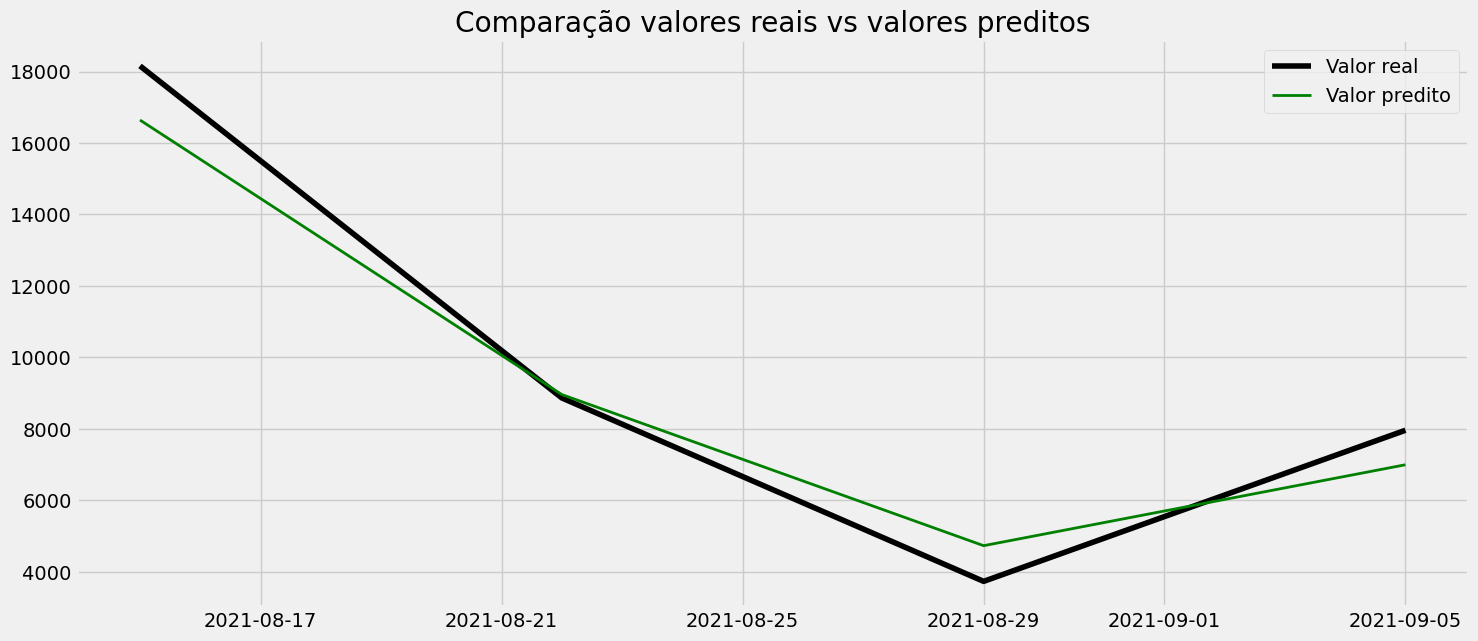

In [395]:
y_validation = pd.DataFrame(y_test)
y_validation['prediction'] = ypred

plt.style.use('fivethirtyeight')
fig, ax = plt.subplots()

ax = sns.lineplot(x = y_validation.index, y = y_validation['produto_quantidade'], color = 'black', label='Valor real', lw=4)
ax = sns.lineplot(x = y_validation.index, y = y_validation['prediction'], color = 'green',label='Valor predito', lw=2)
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_title('Comparação valores reais vs valores preditos')
fig.set_size_inches(16,7)

<AxesSubplot: ylabel='feature'>

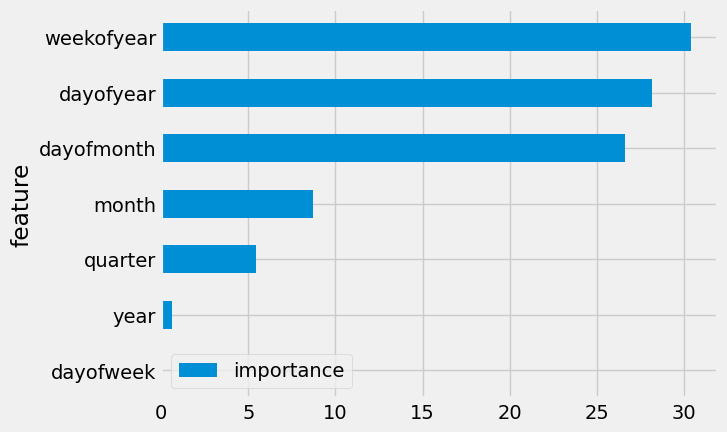

In [406]:
df_feature_importance = (
    pd.DataFrame({
        'feature': cat_model.feature_names_,
        'importance': cat_model.feature_importances_,
    })
    .sort_values('importance', ascending=True).set_index('feature')
)

df_feature_importance.plot(kind='barh')

# Validação final

In [407]:
# Separa a feature dependente das features independentes
X_validation = df_validation.drop(columns='produto_quantidade')
y_validation = df_validation['produto_quantidade']

In [408]:
X_validation

,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
data_emissao_nota,,,,,,,
2021-09-12,6,3,9,2021,255,12,36
2021-09-19,6,3,9,2021,262,19,37
2021-09-26,6,3,9,2021,269,26,38
2021-10-03,6,4,10,2021,276,3,39


In [409]:
# Prediz os valores para validação
ypred = cat_model.predict(X_validation)

In [410]:
metricas_de_avaliacao(y_validation, ypred)

MAE:  1136.56 
 RMSE:  1543.36 
 MAPE:  0.18 
 R2:  0.51


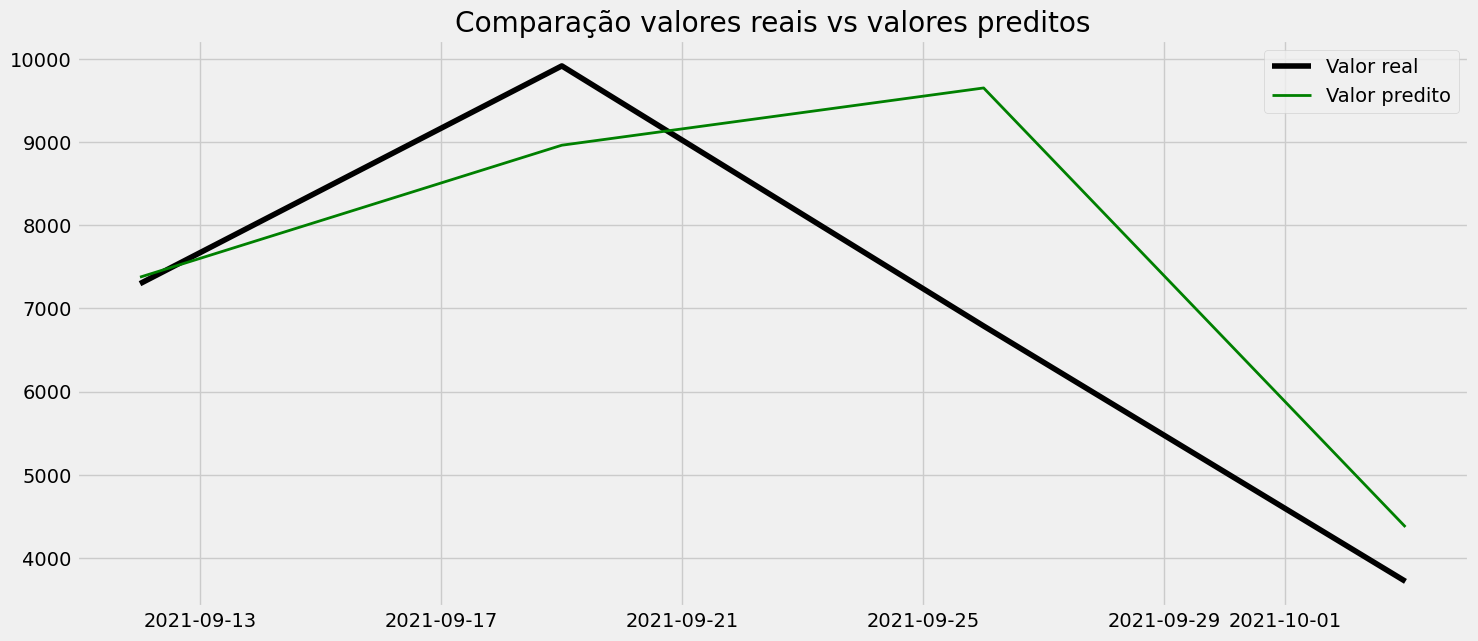

In [411]:
y_validation = pd.DataFrame(y_validation)
y_validation['prediction'] = ypred

plt.style.use('fivethirtyeight')
fig, ax = plt.subplots()

ax = sns.lineplot(x = y_validation.index, y = y_validation['produto_quantidade'], color = 'black', label='Valor real', lw=4)
ax = sns.lineplot(x = y_validation.index, y = y_validation['prediction'], color = 'green',label='Valor predito', lw=2)
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_title('Comparação valores reais vs valores preditos')
fig.set_size_inches(16,7)

<AxesSubplot: ylabel='feature'>

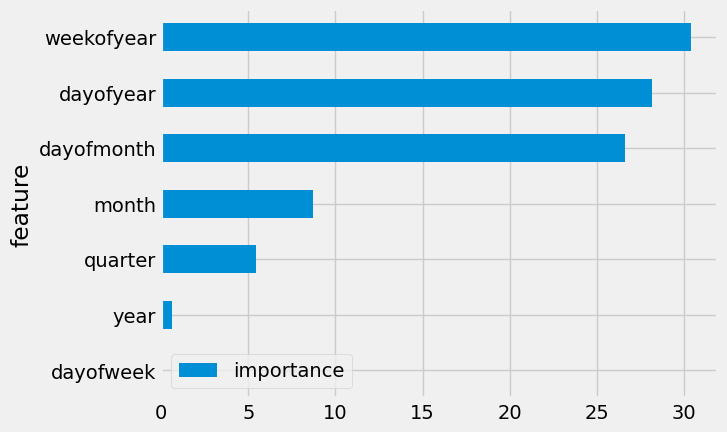

In [412]:
df_feature_importance = (
    pd.DataFrame({
        'feature': lgbm_model.feature_names_,
        'importance': lgbm_model.feature_importances_,
    })
    .sort_values('importance', ascending=True).set_index('feature')
)

df_feature_importance.plot(kind='barh')